In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import gls

In [ ]:
X_train = pd.read_csv('../data/curated/X_train').iloc[:,2:]
y_train = pd.read_csv('../data/curated/y_train').iloc[:,1:]
X_val = pd.read_csv('../data/curated/X_val').iloc[:,2:]
y_val = pd.read_csv('../data/curated/y_val').iloc[:,1:]
X_test = pd.read_csv('../data/curated/X_test').iloc[:,2:]
y_test = pd.read_csv('../data/curated/y_test').iloc[:,1:]

In [ ]:
train = pd.merge(X_train, y_train, left_index=True, right_index=True)
val = pd.merge(X_val, y_val, left_index=True, right_index=True)
test = pd.merge(X_test, y_test, left_index=True, right_index=True)

In [ ]:
train = train[train['income_rate'] > 0.00]
train['inv_ir'] = 1/train['income_rate']

In [ ]:
# use features after feature selection with F-test
cols = ['income_rate','total_adjusted_amount','trip_distance','fare_amount','tip_amount','precipcover','humidity','cloudcover',
'visibility']

In [ ]:
# remove some large numbers to see a more clear pattern
train = train[train['income_rate']<10]
train.count()

In [ ]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(train[cols], plot_kws=dict(s=1, edgecolor="b", linewidth=1),)

In [ ]:
# Pearson correlation coefficient
sns.heatmap(train[cols].corr())
plt.title('Pearson Correlation Metric')
plt.show()

In [ ]:
# since heteroskedasticity 
fit1 = gls(
    formula="income_rate ~ total_adjusted_amount+trip_distance+fare_amount+tip_amount+precipcover+humidity+cloudcover+visibility",
    data=train
).fit()

In [ ]:
# checking heteroskedasticity
train_pred = fit1.fittedvalues.copy()
train_true = train['income_rate'].values.copy()
residual = train_true - train_pred
fig, ax = plt.subplots()
ax.scatter(train_pred, residual)
plt.show()

In [ ]:
fit1.summary()

In [ ]:
plt.scatter(np.log(train['total_adjusted_amount']), train['income_rate'])
train['log_taa'] = np.log(train['total_adjusted_amount'])

In [ ]:
plt.scatter(np.log(train['trip_distance']), train['income_rate'])
train['log_td'] = np.log(train['trip_distance'])

In [ ]:
plt.scatter(np.log(train['tip_amount']), train['income_rate'])
train['log_ta'] = np.log(train['tip_amount'])

In [ ]:
plt.scatter(np.log(train['fare_amount']), train['income_rate'])
train['log_fa'] = np.log(train['fare_amount'])

In [ ]:
fit2 = gls(
    formula="income_rate ~ log_taa+log_td+log_fa+log_ta+precipcover+humidity+cloudcover+visibility",
    data=train
).fit()

In [ ]:
fit2.summary()

In [ ]:
# decide to use fit1
cols1 = ['total_adjusted_amount','trip_distance','fare_amount','tip_amount','precipcover','humidity','cloudcover',
'visibility']
train_predictions = fit1.predict(train[cols1])
val_predictions = fit1.predict(val[cols1])
test_predictions = fit1.predict(test[cols1])

In [ ]:
# calculate r square for validation set
import numpy as np
import math
corr_matrix_train = np.corrcoef(train['income_rate'], train_predictions)
corr_train = corr_matrix_train[0,1]
R_sq_train = corr_train**2
MSE_train = np.square(np.subtract(train['income_rate'],train_predictions)).mean()

In [ ]:
print("r2_score for training set: {:.3f}".format(R_sq_train))
print("RMSE for training set: {:.3f}".format(math.sqrt(MSE_train)))

In [ ]:
# calculate r square for validation set
corr_matrix_val = np.corrcoef(val['income_rate'], val_predictions)
corr_val = corr_matrix_val[0,1]
R_sq_val = corr_val**2
MSE_val = np.square(np.subtract(val['income_rate'],val_predictions)).mean()

In [ ]:
print("r2_score for validation set: {:.3f}".format(R_sq_val))
print("RMSE for validation set: {:.3f}".format(math.sqrt(MSE_val)))

In [ ]:
# calculate r square for test set
corr_matrix_test = np.corrcoef(test['income_rate'], test_predictions)
corr_test = corr_matrix_test[0,1]
R_sq_test = corr_test**2
MSE_test = np.square(np.subtract(test['income_rate'],test_predictions)).mean()

In [ ]:
print("r2_score for testing set: {:.3f}".format(R_sq_test))
print("RMSE for testing set: {:.3f}".format(math.sqrt(MSE_test)))

In [ ]:
test_predictions.to_csv('../data/curated/LR_test_prediction.csv')

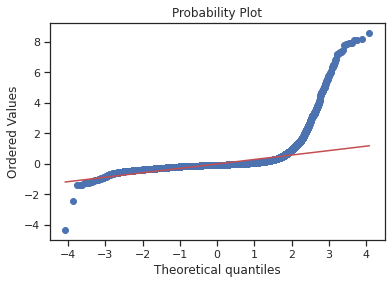

In [51]:
# normality distribution check
fig, ax = plt.subplots()
sp.stats.probplot(residual, plot=ax, fit=True)
plt.show()